In [ ]:
#| default_exp kalman
%load_ext autoreload
%autoreload 2


In [ ]:
#| export
import jax.numpy as jnp
import jax.random as jrn
import jax.scipy.linalg as jsla
import tensorflow_probability.substrates.jax.distributions as tfd
from jax import vmap
from jax.lax import scan
from jaxtyping import Array, Float, PRNGKeyArray

from isssm.typing import GLSSM, FilterResult, Observations, SmootherResult
from isssm.util import MVN_degenerate as MVN, vmatmul

In [ ]:
# libraries for this notebook
from isssm.models.stsm import stsm
import jax
import numpy.testing as npt
import matplotlib.pyplot as plt
from isssm.glssm import simulate_glssm
from isssm.typing import GLSSM

In [ ]:
# use x86 for testing purposes
jax.config.update("jax_enable_x64", True)

# Kalman filter and smoother variants in JAX


Consider a [GLSSM](00_glssm.ipynb) of the form
$$
\begin{align*}
    X_0 &\sim \mathcal N (x_0, \Sigma_0) &\\
    X_{t + 1} &= A_t X_{t} + \varepsilon_{t + 1} &t = 0, \dots, n - 1\\
    \varepsilon_t &\sim \mathcal N (0, \Sigma_t) & t = 1, \dots, n \\
    Y_t &= B_t X_t + \eta_t & t =0, \dots, n & \\
    \eta_t &\sim \mathcal N(0, \Omega_T), & t=0, \dots, n.
\end{align*}
$$



For $t, s \in \{0, \dots, n\}$ consider the following BLPs and associated covariance matrices
$$
\begin{align*}
    \hat X_{t|s} &= \mathbf E \left( X_t | Y_s, \dots, Y_0\right) \\
    \Xi_{t | s} &= \text{Cov} \left(X_t | Y_s, \dots, Y_0 \right)\\
    \hat Y_{t|s} &= \mathbf E \left( Y_t | Y_s, \dots, Y_0\right) \\
    \Psi_{t | s} &= \text{Cov} \left(Y_t | Y_s, \dots, Y_0 \right)
\end{align*}
$$

The Kalman filter consists of the following two-step recursion:

#### Initialization
$$
\begin{align*}
\hat X_{0|0} &= x_0\\
\Xi_{0|0} &= \Sigma_0
\end{align*}
$$

Iterate for $t = 0, \dots, n-1$

#### Prediction
$$
\begin{align*}
    \hat X_{t + 1|t} &= A_t \hat X_{t | t} \\
    \Xi_{t + 1 | t} &= A_t \Xi_{t|t} A_t^T + \Sigma_t\\
\end{align*}
$$

#### Filtering
$$
\begin{align*}
    \hat Y_{t + 1 | t} &= B_t \hat X_{t + 1 | t} \\
    \Psi_{t + 1| t} &= B_{t + 1} \Xi_{t + 1 | t} B_{t + 1}^T + \Omega_{t + 1}\\
    K_t &= \Xi_{t + 1 | t} B_{t + 1}^T \Psi_{t + 1 | t} ^{-1} \\
    \hat X_{t + 1 | t + 1} &= \hat X_{t + 1 | t} + K_t (Y_{t + 1} - \hat Y_{t + 1 | t})\\
    \Xi_{t + 1 | t + 1} &= \Xi_{t + 1 | t} - K_t \Psi_{t + 1| t} K_t^T 
\end{align*}
$$


In [ ]:
#| export


def _predict(
    x_filt: Float[Array, "m"], # $X_{t|t}$
    Xi_filt: Float[Array, "m m"], # $\Xi_{t|t}
    A: Float[Array, "m m"], # $A_t$
    Sigma: Float[Array, "m m"], # $\Sigma_{t + 1}
):
    """perform a single prediction step"""
    x_pred = A @ x_filt
    Xi_pred = A @ Xi_filt @ A.T + Sigma

    return x_pred, Xi_pred


def _filter(
    x_pred: Float[Array, "m"], 
    Xi_pred: Float[Array, "m m"],
    y: Float[Array, "p"],
    B: Float[Array, "p m"],
    Omega: Float[Array, "p p"],
):
    """perform a single filtering step"""
    y_pred = B @ x_pred
    Psi_pred = B @ Xi_pred @ B.T + Omega
    K = Xi_pred @ B.T @ jnp.linalg.pinv(Psi_pred)#jsla.solve(Psi_pred, B).T
    x_filt = x_pred + K @ (y - y_pred)
    Xi_filt = Xi_pred - K @ Psi_pred @ K.T

    return x_filt, Xi_filt


def kalman(
    y: Observations, # observatoins
    glssm: GLSSM, # model
) -> FilterResult: # filtered & predicted states and covariances
    """Perform the Kalman filter"""
    x0, A, Sigma, B, Omega = glssm
    def step(carry, inputs):
        x_filt, Xi_filt = carry
        y, Sigma, Omega, A, B = inputs

        x_pred, Xi_pred = _predict(x_filt, Xi_filt, A, Sigma)
        x_filt_next, Xi_filt_next = _filter(x_pred, Xi_pred, y, B, Omega)

        return (x_filt_next, Xi_filt_next), (x_filt_next, Xi_filt_next, x_pred, Xi_pred)

    # artificial state X_{-1} with mean x_0
    # covariance zero, transition identity
    # will lead to X_0 having correct predictive distribution
    # this avoids having to compute a separate filtering step beforehand

    m, = x0.shape
    A_ext = jnp.concatenate(
        (jnp.eye(m)[jnp.newaxis], A)
    )

    _, (x_filt, Xi_filt, x_pred, Xi_pred) = scan(
        step, (x0, jnp.zeros_like(Sigma[0])), (y, Sigma, Omega, A_ext, B)
    )

    return FilterResult(x_filt, Xi_filt, x_pred, Xi_pred)

Let us check that our implementation works as expected by simulating a single sample from the joint distribution of a [structural time series model](models/10_stsm.ipynb) with seasonality of order 2. 

In [ ]:
glssm_model = stsm(jnp.zeros(4), 0., .1, .1, 100, jnp.eye(4), 3, 2)

key = jrn.PRNGKey(53405234)
key, subkey = jrn.split(key)
(x,), (y,) = simulate_glssm(glssm_model, 1, subkey)

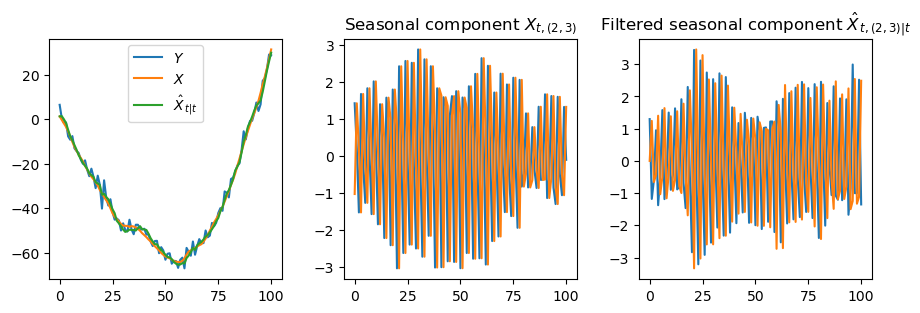

In [ ]:
x_filt, Xi_filt, x_pred, Xi_pred = kalman(y, glssm_model)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
fig.tight_layout()

ax1.set_title("")
ax1.plot(y, label="$Y$")
ax1.plot(x[:,0], label="$X$")
ax1.plot(x_filt[:,0], label="$\\hat X_{{t|t}}$")
ax1.legend()

ax2.plot(x[:,2:])
ax2.set_title("Seasonal component $X_{{t, (2,3)}}$")

ax3.set_title("Filtered seasonal component $\\hat X_{{t, (2,3)|t}}$")
ax3.plot(x_filt[:,2:])

plt.show()


The **Kalman smoother** uses the filter result to obtain $\hat X_{t | n}$ and $\Xi_{t | n}$ for $t = 0, \dots n$.

It is based on the following recursion with initialisation by the filtering result $\hat X_{n | n}$ and $\Xi_{n|n}$ and the (reverse) **gain** $G_t$. 

$$
\begin{align*}
    G_t &= \Xi_{t | t} A_t \Xi_{t + 1 | t} ^{-1}\\
    \hat X_{t | n} &= \hat X_{t | t} + G_t (\hat X_{t + 1| n} - \hat X_{t + 1 | t}) \\
    \Xi_{t | n} &= \Xi_{t | t} - G_t (\Xi_{t + 1 | t} - \Xi_{t + 1 | n}) G_t^T
\end{align*}
$$

In [ ]:
#| export
State = Float[Array, "m"]
StateCov = Float[Array, "m m"]
StateTransition = Float[Array, "m m"]


def _smooth_step(
    x_filt: State,
    x_pred_next: State,
    x_smooth_next: State,
    Xi_filt: StateCov,
    Xi_pred_next: StateCov,
    Xi_smooth_next: StateCov,
    A: StateTransition
):
    err = x_smooth_next - x_pred_next
    Gain = Xi_filt @ A.T @ jnp.linalg.pinv(Xi_pred_next)

    x_smooth = x_filt + Gain @ err
    Xi_smooth = Xi_filt - Gain @ (Xi_pred_next - Xi_smooth_next) @ Gain.T

    return (x_smooth, Xi_smooth)


def smoother(
    filter_result: FilterResult,
    A: Float[Array, "n m m"] # transition matrices
) -> SmootherResult:
    """perform the Kalman smoother"""
    x_filt, Xi_filt, x_pred, Xi_pred = filter_result
    def step(carry, inputs):
        x_smooth_next, Xi_smooth_next = carry
        x_filt, Xi_filt, x_pred_next, Xi_pred_next, A = inputs

        x_smooth, Xi_smooth = _smooth_step(
            x_filt, x_pred_next, x_smooth_next, Xi_filt, Xi_pred_next, Xi_smooth_next,A
        )

        return (x_smooth, Xi_smooth), (x_smooth, Xi_smooth)

    _, (x_smooth, Xi_smooth) = scan(
        step, (x_filt[-1], Xi_filt[-1]), (x_filt[:-1], Xi_filt[:-1], x_pred[1:], Xi_pred[1:], A), reverse=True
    )

    x_smooth = jnp.concatenate([x_smooth, x_filt[None, -1]])
    Xi_smooth = jnp.concatenate([Xi_smooth, Xi_filt[None, -1]])

    return SmootherResult(x_smooth, Xi_smooth)

Let us apply the Kalman smoother to our simulated observations.

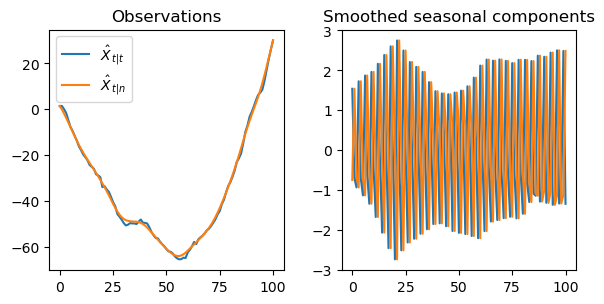

In [ ]:
filtered = kalman(y, glssm_model)

x_smooth, Xi_smooth = smoother(filtered, glssm_model.A)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6, 3))
fig.tight_layout()
ax1.set_title("filter and smoother")
ax1.plot(x_filt[:,0], label="$\\hat X_{{t | t}} $")
ax1.plot(x_smooth[:,0], label="$\\hat X_{{t | n}}$")
ax1.legend()

ax2.set_title("Smoothed seasonal components")
ax2.plot(x_smooth[:,2:])

plt.show()


The smoothed states are indeed smoother.

## Sampling from the smoothing distribution

After having run the Kalman filter we can use a recursion due to Frühwirth-Schnatter [@Fruhwirth-Schnatter1994Data] to obtain samples from the joint conditional distribution the states given observations.

By the dependency structure of states and observations the conditional densities can be factorized in the following way:

$$
\begin{align*}
p(x_0, \dots, x_n | y_0, \dots, y_n) &=  p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, \dots, x_n, y_0, \dots, y_n) \\
&= p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, y_0, \dots, y_n)
\end{align*}
$$

and the conditional distributions are again gaussian with conditional expecatation 
$$
\mathbf E (X_{t} | X_{t + 1}, Y_0, \dots, Y_n) = \hat X_{t|t} + G_t (X_{t + 1} - \hat X_{t + 1|t})
$$ and conditional covariance matrix 
$$
\text{Cov} (X_t | X_{t + 1}, Y_0, \dots, Y_n) = \Xi_{t|t} - G_t\Xi_{t + 1 | t} G_t^T
$$

where $G_t = \Xi_{t|t} A_t^T \Xi_{t + 1|t}^{-1}$ is the smoothing gain.

In [ ]:
# | export
def _simulate_smoothed_FW1994(
    x_filt: Float[Array, "n+1 m"],
    Xi_filt: Float[Array, "n+1 m m"],
    Xi_pred: Float[Array, "n+1 m m"],
    A: Float[Array, "n m m"],
    N: int, # number of samples
    key: PRNGKeyArray # the random states
) -> Float[Array, "N n+1 m"]: # array of N samples from the smoothing distribution
    r"""Simulate from smoothing distribution $p(X_0, \dots, X_n|Y_0, \dots, Y_n)$"""

    key, subkey = jrn.split(key)
    X_n = MVN(x_filt[-1], Xi_filt[-1]).sample(N, subkey)

    def sample_backwards(carry, inputs):
        X_smooth_next, key = carry
        x_filt, Xi_filt, Xi_pred, A = inputs

        G = Xi_filt @ jnp.linalg.solve(Xi_pred, A).T

        cond_expectation = x_filt + vmatmul(G, X_smooth_next - (A @ x_filt)[None])
        cond_covariance = Xi_filt - G @ Xi_pred @ G.T

        key, subkey = jrn.split(key)
        new_samples = MVN(cond_expectation, cond_covariance).sample(seed=subkey)
        return (new_samples, key), new_samples

    key, subkey = jrn.split(key)
    _, X = scan(
        sample_backwards,
        (X_n, subkey),
        (x_filt[:-1], Xi_filt[:-1], Xi_pred[1:], A),
        reverse=True,
    )

    X_full = jnp.concatenate((X, X_n[None]))

    return X_full.transpose((1, 0, 2))


def FFBS(
    y: Observations, # Observations $y$
    model: GLSSM, # GLSSM
    N: int, # number of samples 
    key: PRNGKeyArray # random state
) -> Float[Array, "N n+1 m"]: # N samples from the smoothing distribution
    r"""The Forward-Filter Backwards-Sampling Algorithm from [@Fruhwirth-Schnatter1994Data]."""
    x_filt, Xi_filt, _, Xi_pred = kalman(y, model)

    key, subkey = jrn.split(key)
    return _simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, model.A, N, subkey)

In [ ]:
key, subkey = jrn.split(key)
X_sim, = FFBS(y, glssm_model, 1, subkey)

assert X_sim.shape == x.shape

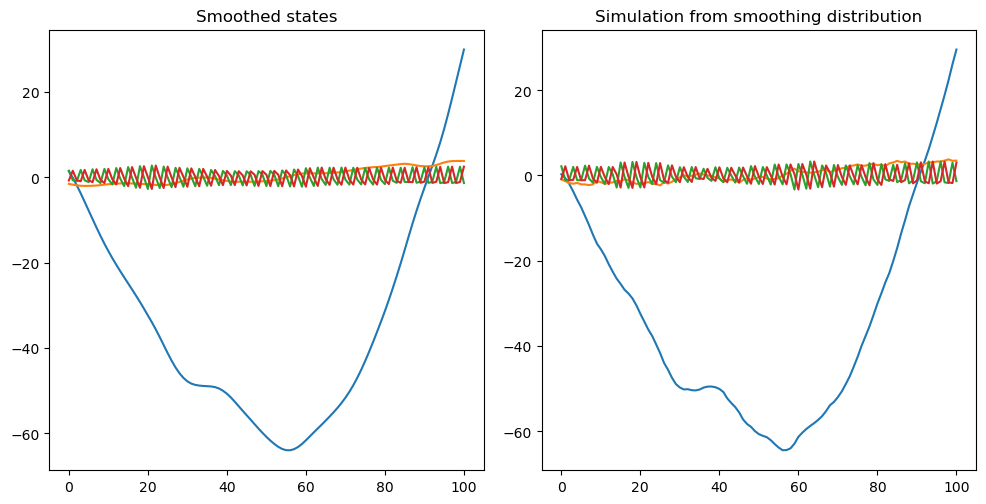

In [ ]:
x_smooth, Xi_smooth = smoother(filtered, glssm_model.A)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
fig.tight_layout()
ax1.set_title("Smoothed states")
ax1.plot(x_smooth)
ax2.set_title("Simulation from smoothing distribution")
ax2.plot(X_sim)
plt.show()

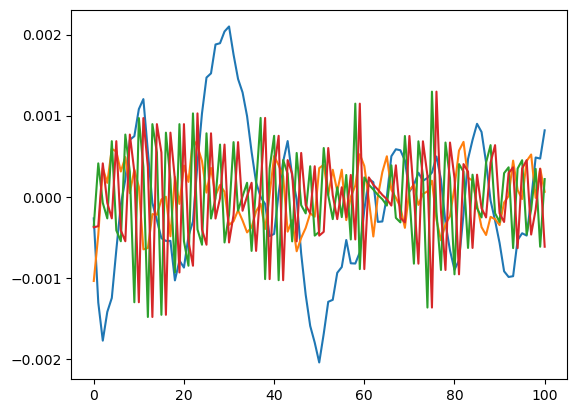

In [ ]:
#| hide
# sanity check: do marginal mean of simulation coincide with Kalman smoother?
key, subkey = jrn.split(key)
X_sim = _simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, glssm_model.A, 1e6, subkey)

plt.plot(X_sim.mean(axis = 0) - x_smooth)
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()